# **The Storm Of the Century : MSLP ERA5**
***

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
from scipy import ndimage  
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2', 
    consolidated=True
)

In [3]:
reanalysis

<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>

## **Date Input**

In [4]:
startYear = 1993
startMonth = 3
startDay = 7
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 1993
endMonth = 3
endDay = 15
endHour = 0
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)

In [5]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

/tmp/ipykernel_742505/666960345.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dateList = pd.date_range(startDateTime, endDateTime,freq="6H")


DatetimeIndex(['1993-03-07 00:00:00', '1993-03-07 06:00:00',
               '1993-03-07 12:00:00', '1993-03-07 18:00:00',
               '1993-03-08 00:00:00', '1993-03-08 06:00:00',
               '1993-03-08 12:00:00', '1993-03-08 18:00:00',
               '1993-03-09 00:00:00', '1993-03-09 06:00:00',
               '1993-03-09 12:00:00', '1993-03-09 18:00:00',
               '1993-03-10 00:00:00', '1993-03-10 06:00:00',
               '1993-03-10 12:00:00', '1993-03-10 18:00:00',
               '1993-03-11 00:00:00', '1993-03-11 06:00:00',
               '1993-03-11 12:00:00', '1993-03-11 18:00:00',
               '1993-03-12 00:00:00', '1993-03-12 06:00:00',
               '1993-03-12 12:00:00', '1993-03-12 18:00:00',
               '1993-03-13 00:00:00', '1993-03-13 06:00:00',
               '1993-03-13 12:00:00', '1993-03-13 18:00:00',
               '1993-03-14 00:00:00', '1993-03-14 06:00:00',
               '1993-03-14 12:00:00', '1993-03-14 18:00:00',
               '1993-03-

## **Area and Domain**

In [6]:
lonW = -99 + 360
lonE = -59 + 360
latS = 20
latN = 50
inc=.25
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latN,latS-inc,-inc) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+inc,+inc) # Need to match longitude values to those of the coordinate variable
constrainLat, constrainLon = (0.6, 7)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

## **Variables**

In [7]:
plevel1=500
plevel2=1000
SLP = reanalysis['mean_sea_level_pressure'].sel(time=dateList,latitude=latRange,longitude=lonRange)
Z1 = reanalysis['geopotential'].sel(time=dateList,level=plevel1,latitude=latRange,longitude=lonRange)
Z2 = reanalysis['geopotential'].sel(time=dateList,level=plevel2,latitude=latRange,longitude=lonRange)

In [8]:
lats = SLP.latitude
lons = SLP.longitude

## **MetPy Calculations**

In [9]:
SLP = SLP.metpy.convert_units('hPa')
HGHT1 =  mpcalc.geopotential_to_height(Z1)
HGHT2 =  mpcalc.geopotential_to_height(Z2)

HGHT1 = HGHT1.metpy.convert_units('dam')
HGHT2 = HGHT2.metpy.convert_units('dam')
Thickness = HGHT1 - HGHT2

In [10]:
SLP = SLP.compute()
Thickness = Thickness.compute()

## **Graphing**

In [11]:
contour_int=4
minSLP, maxSLP = (944,1044)
SLPContours = np.arange(minSLP, maxSLP, contour_int)

cint1 = np.arange(0,534,6)
cint2 = np.array([540])
cint3 = np.arange(546,1000,6)

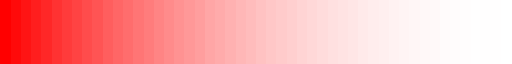

In [12]:
colors = [(1,0,0,1),(1, 1, 1, 0)]
n_bins = 50 # Number of bins

# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("Color Bar",colors, N=n_bins)
cmap

In [1]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('ERA5, Valid at: '+ timeStr)
    tl2 = "MSLP (hPa)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    ax.add_feature (cfeature.STATES.with_scale(res))
    ax.add_feature (cfeature.RIVERS.with_scale(res))
    ax.add_feature (cfeature.LAND.with_scale(res))
    ax.add_feature (cfeature.COASTLINE.with_scale(res))
    ax.add_feature (cfeature.LAKES.with_scale(res))
    ax.add_feature (cfeature.STATES.with_scale(res))
    ax.add_feature(cfeature.OCEAN)
    
 
    # Contour lines 
    cSLP = ax.contour(lons, lats, SLP.sel(time=time), levels=SLPContours, colors='black', linewidths=3, transform=proj_data)
    ax.clabel(cSLP, inline=1, fontsize=12, fmt='%.0f')

    # Thicnkess < 540
    CS1 = ax.contour(lons,lats,Thickness.sel(time=time),cint1,linewidths=1,colors='blue',linestyles='--', transform=proj_data)
    ax.clabel(CS1, inline=1, fontsize=13,fmt='%.0f')
    #540 DAM
    CS2 = ax.contour(lons,lats,Thickness.sel(time=time),cint2,linewidths=1.5,colors='blue',linestyles='solid', transform=proj_data)
    ax.clabel(CS2, inline=1, fontsize=13,fmt='%.0f')
    #Thickness > 540
    CS3 = ax.contour(lons,lats,Thickness.sel(time=time),cint3,linewidths=1,colors='red',linestyles='--', transform=proj_data)
    ax.clabel(CS3, inline=1, fontsize=13,fmt='%.0f')
    

    #contourf=ax.contourf(lons,lats,SLP.sel(time=time),levels=SLPContours,cmap=cmap,transform=proj_data,zorder=1)
    #cbar = plt.colorbar(contourf)
    #cbar.set_label('MSLP hPA', rotation=270, labelpad=15)
    
    
    # Wind barbs
    #skip = 4
    #ax.barbs(lons[::skip],lats[::skip],UKts.sel(time=time)[::skip,::skip].values, VKts.sel(time=time)[::skip,::skip].values, color='black',zorder=2,transform=proj_data)

    title = plt.title(title_line,fontsize=16)

NameError: name 'dateList' is not defined